In [156]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import torch
import torch_geometric
import jupyter_black

jupyter_black.load()



# Load Data

In [125]:
from torch_geometric.datasets import IMDB
import torch_geometric.transforms as T

transform = T.ToUndirected()  # Add reverse edge types.
data = IMDB(root="./data/IMDB/", transform=transform)[0]

# Making the classification problem binary by merging class 2 and 1
data["movie"].y[data["movie"].y == 2] = 1

# Add edge attributes to all edges. The model expects edge attributes, and will produce error if it does not exist
for edge_type in data.edge_types:
    data[edge_type].edge_attr = torch.ones(
        [data[edge_type].edge_index.shape[1], 1], dtype=torch.float32
    )

# Reducing the number of features by removing those that are most frequently equal to zero
feature_mask = (data["movie"].x != 0).sum(dim=0) > 100
data["movie"].x = data["movie"].x[:, feature_mask]

feature_mask = (data["director"].x != 0).sum(dim=0) > 100
data["director"].x = data["director"].x[:, feature_mask]

feature_mask = (data["actor"].x != 0).sum(dim=0) > 300
data["actor"].x = data["actor"].x[:, feature_mask]

# Casting the reponse variable to float and reshaping it to match the exepcted dimension
data["movie"].y = data["movie"].y.reshape([len(data["movie"].y), 1]).to(torch.float32)

# DEV

C:\Users\FJO017\Anaconda3\envs\heterogeneous_mpnn\lib\site-packages\torch_geometric\nn\conv\hetero_conv.py:62: UserWarning: There exist node types ({'director', 'actor'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behavior.
  warnings.warn(
C:\Users\FJO017\Anaconda3\envs\heterogeneous_mpnn\lib\site-packages\torch_geometric\nn\conv\hetero_conv.py:62: UserWarning: There exist node types ({'director'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behavior.
  warnings.warn(
C:\Users\FJO017\Anaconda3\envs\heterogeneous_mpnn\lib\site-packages\torch_geometric\nn\conv\hetero_conv.py:62: UserWarning: There exist node types ({'actor'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected b

Epoch #0
Epoch #25
Epoch #50
Epoch #75
Epoch #100
Early stopping. Epoch #105


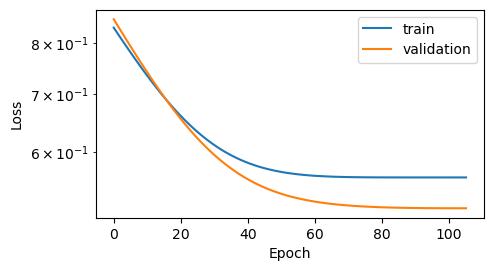

In [204]:
import models_mpnn, models_hmct, utils

node_type = "movie"
max_epochs = 1000

# Initialize model
model = models_mpnn.NNConv2Layer(data, node_type)
model = models_hmct.Hmct3Layer(data, node_type)
utils.get_num_params(model)


train_hist = pd.DataFrame(columns=["loss_train", "loss_val"])

# Initialize the loss-function and optimizer
loss_fun = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)


y = data[node_type].y
# Training model with early stopping
model.train()
for epoch in range(max_epochs):
    optimizer.zero_grad()
    pred = model.forward(data.x_dict, data.edge_index_dict, data.edge_attr_dict)
    loss_train = loss_fun(
        pred[data[node_type].train_mask], y[data[node_type].train_mask]
    )

    loss_val = loss_fun(pred[data[node_type].val_mask], y[data[node_type].val_mask])

    train_hist.loc[epoch] = loss_train.item(), loss_val.item()
    if (
        epoch > 0
        and train_hist.loc[epoch, "loss_val"] > train_hist.loc[epoch - 1, "loss_val"]
    ):
        print(f"Early stopping. Epoch #{epoch}")
        break
    if epoch % 25 == 0:
        print(f"Epoch #{epoch}")

    loss_train.backward()
    optimizer.step()

train_hist

fig, ax = plt.subplots(figsize=(5, 2.7))
ax.plot(train_hist["loss_train"], label="train")
ax.plot(train_hist["loss_val"], label="validation")
ax.set_yscale("log")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.legend()
plt.show()

In [205]:
with torch.no_grad():
    pred = model.forward(data.x_dict, data.edge_index_dict, data.edge_attr_dict)

from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve

pred_train = pred[data[node_type].train_mask]
y_train = y[data[node_type].train_mask]

pred_val = pred[data[node_type].val_mask]
y_val = y[data[node_type].val_mask]

pred_test = pred[data[node_type].test_mask]
y_test = y[data[node_type].test_mask]

print(roc_auc_score(y_train.detach().numpy(), pred_train.detach().numpy()))
print(roc_auc_score(y_val.detach().numpy(), pred_val.detach().numpy()))
print(roc_auc_score(y_test.detach().numpy(), pred_test.detach().numpy()))

0.5858333333333334
0.5291214587100663
0.5407056991640649
